In [103]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share
bp.math.set_dt(0.05)

In [49]:
class BaseAMPASyn(bp.dyn.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.001, E=20, alpha=5,
               beta=1, #0.18, 
               T=1, T_duration=1, method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)

    def derivative(self, g, t, TT):
        dg = self.alpha * TT * (1 - g) - self.beta * g
       
        # dg = -g + ((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8))  # according to paper 
        return dg
    
   

In [ ]:
class AMPAAll2All(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAAll2All, self).__init__(*args, **kwargs)
    
     # connection matrix
    self.conn_mat = self.conn.require('conn_mat').astype(float)

    # synapse gating variable
    # -------
    # The synapse variable has the shape of the post-synaptic group
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
    

  def update(self, x=None):
    _t, _dt = bp.share['t'], bp.share['dt']
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    # TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
          #*1/(1+bm.exp(-(self.pre.V-20)/2)))
    # TT = 1/(1+bm.exp(-(self.pre.V-20)/2))
    # TT = TT.reshape((-1, 1))  # NOTE: here is the difference
    TT = 1 / (1 + bm.exp(-(self.pre.V + 3) / 8))
    TT = TT.reshape((-1, 1)) #* self.conn_mat
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    g_post = self.g.sum(axis=0) # NOTE: here is also different

    self.post.input += - bm.dot(self.g_max , g_post) * (self.E - self.post.V) +
    print('output =', self.post.input)
    

In [50]:
num = 100
neu = A2(num)
neu.V[:] =  bm.random.normal(size=num) * 20

# Random network connectivity
conn = bp.connect.FixedProb(prob=0.6, include_self=True) # 10% connection probability, adjust as needed
syn = bp.synapses.AMPA(neu, neu, conn, #bp.connect.All2All(include_self=True),
                 output=bp.synouts.COBA(E=20.),
                 alpha=5, beta=1, g_max=6e-3)
#bp.synapses.GABAa(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False),stop_spike_gradient=False)
#AMPAAll2All(pre=neu, post=neu, conn=conn)

shape = (100,100)
syn.g_max = bp.init.Normal(mean=0.1, scale=0.02)(shape) /10
print('weights are =', syn.g_max.shape)

# Random input currents
input_currents = 1# bm.random.uniform(9.0, 10.0, num)

net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input', input_currents])

NameError: name 'A2' is not defined

In [ ]:
runner.run(duration=1500.)  # Run for 500 seconds (assuming dt=0.1ms)

fig, gs = bp.visualize.get_figure(2, 1, 3, 15)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts, runner.mon['neu.V'])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['neu.spike'], show=True)
plt.show()

In [ ]:
import numpy as np

In [ ]:
class EINet(bp.DynSysGroup):
  def __init__(self):
    super().__init__()
    self.N = bp.neurons.HH(100) #bp.dyn.LifRef(100, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                          # V_initializer=bp.init.Normal(-55., 2.))
    self.delay = bp.VarDelay(self.N.spike, entries={'I': None})
    # self.E = bp.dyn.ProjAlignPreMg2(comm=bp.dnn.EventJitFPHomoLinear(80, 100, prob=1, weight=0.01),
    #                                  syn=bp.dyn.GABAa.desc(80, alpha=0.53, beta=0.18, T=1.0, T_dur=1.0),
    #                                  out=bp.dyn.COBA.desc(E=20.),
    #                                  post=self.N)
    # self.I = bp.dyn.ProjAlignPreMg2(comm=bp.dnn.EventJitFPHomoLinear(20, 100, prob=1, weight=0.01),
    #                                  syn=bp.dyn.GABAa.desc(20, alpha=0.53, beta=0.18, T=1.0, T_dur=1.0),
    #                                  out=bp.dyn.COBA.desc(E=-75.),
    #                                  post=self.N)
    self.E = bp.synapses.Exponential(pre=E, post=I, conn=bp.conn.FixedProb(prob), tau=tau_Es, g_max=JIE)

  def update(self, input):
    spk = self.delay.at('I')
    self.E(spk[:80])
    self.I(spk[80:])
    self.delay(self.N(input))
    return self.N.spike.value
 
  def run(self, ids, inputs):  # the most import function!!!
    for i, inp in zip(ids, inputs):
      bp.share.save(i=i, t=bm.get_dt() * i)
      self.update(inp)
    return self.N.spike.value


In [ ]:
n_step_per_monitor = 10

In [ ]:
indices = np.arange(30000).reshape(-1, n_step_per_monitor)
inputs = np.ones(indices.shape) * 20.

In [ ]:
model = EINet()
spks = bm.for_loop(model.run, (indices, inputs), progress_bar=True)
spks.shape

In [ ]:
bp.visualize.raster_plot(indices[:, 0], spks, show=True)

In [52]:
import brainpy as bp
import brainpy.math as bm
import numpy as np

bp.math.set_platform('cpu')


In [53]:
num_exc = 160
num_inh = 40
Cm = 1  # Membrane Capacitance [pF]

gl = 0.03  # Leak Conductance   [nS]
g_Na = 120. 
g_K = 36. #* 1000  # K Conductance      [nS]
El = -54.387  # Resting Potential [mV]
ENa = 50.  # reversal potential (Sodium) [mV]
EK = -77.  # reversal potential (Potassium) [mV]
VT = -63.
V_th = 20.

# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]

# Reversal potentials
Ee = 20.  # Excitatory reversal potential (mV)
Ei = -75.  # Inhibitory reversal potential (Potassium) [mV]

# excitatory synaptic weight
we = 0.6  # excitatory synaptic conductance [nS]

# inhibitory synaptic weight
wi = 6.7  # inhibitory synaptic conductance [nS]

In [54]:
class HH(bp.dyn.NeuDyn):
    def __init__(self, size, method='exp_auto'):
        super(HH, self).__init__(size)

        # variables
        self.V = bm.Variable(El + (bm.random.randn(self.num) * 5 - 5))
        self.m = bm.Variable(bm.zeros(self.num))
        self.n = bm.Variable(bm.zeros(self.num))
        self.h = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.input = bm.Variable(bm.zeros(size))

        def dV(V, t, m, h, n, Isyn):
            INa = g_Na * m ** 3 * h * (V - ENa)
            IK = g_K * n ** 4 * (V - EK)
            IL = gl * (V - El)
            dVdt = (- INa - IK - IL + Isyn) / Cm
            return dVdt

        def dm(m, t, V):
            alpha =  (0.1*V+4) / (-bm.exp(-4 - 0.1*V)+1) #0.1 * (25-V) / (bm.exp(-0.1 * (V - 25)) - 1)
            beta = 4.0*bm.exp(-V-65/18.0) # 4 * bm.exp(-V / 18)
            dmdt = alpha * (1 - m) - beta * m
            return dmdt

        def dn(n, t, V):
            alpha = 0.01*(55.0+V)/ (-bm.exp(-5.5-0.1*V )+1) #0.01 * (10-V) / (bm.exp(0.1 * (10-V)) - 1)
            beta = 0.125*bm.exp(-V-65/80.0) #0.125 * bm.exp(-V / 80)
            dndt = alpha * (1 - n) - beta * n
            return  dndt

        def dh(h, t, V):
            alpha = 0.07*bm.exp(-V-65/20.0) #0.07 * bm.exp(-V / 20)
            beta = 1/(1+bm.exp(-3.5-0.1*V)) #1 / (bm.exp(0.1 * (-V + 30)) + 1)
            dhdt = alpha * (1 - h) - beta * h
            return dhdt
        
        
        

        # functions
        self.integral = bp.odeint(bp.JointEq([dV, dm, dh, dn]), method='exp_auto')

    def update(self):
        tdi = bp.share.get_shargs()
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, tdi.t, Isyn=self.input, dt=tdi.dt)
        self.spike.value = bm.logical_and(self.V < V_th, V >= V_th)
        self.m.value = m
        self.h.value = h
        self.n.value = n
        self.V.value = V
        self.input[:] = 0.

In [191]:
import brainpy as bp
import brainpy.math as bm
import unittest

show = False


class HH(bp.dyn.CondNeuGroup):
    def __init__(self, size,method='exp_auto'):
        super(HH, self).__init__(size)
        self.INa = bp.channels.INa_HH1952(size, )
        self.IK = bp.channels.IK_HH1952(size, )
        self.IL = bp.channels.IL(size, E=-54.387, g_max=0.3)

        
class HH2(bp.dyn.CondNeuGroupLTC): #(bp.dyn.HHLTC):
    def __init__(self, size):
        super(HH2, self).__init__(size)
        self.INa = bp.channels.INa_HH1952(size,  g_max=120.) ##bp.channels.INa_TM1991(size, g_max=100., V_sh=-63.)
        self.IK =  bp.channels.IK_HH1952(size, E = -77., g_max= 36.)#bp.channels.IK_TM1991(size, g_max=30., V_sh=-63.)
        self.IL = bp.channels.IL(size, E=-54.4, g_max=0.03)
        



class HHv2(bp.dyn.NeuDyn):
    def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03, V_th=20., C=1.0):
        super().__init__(size=size)

        # initialize parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th

        # initialize variables
        self.V = bm.Variable(bm.random.randn(self.num) - 70.)
        self.m = bm.Variable(0.5 * bm.ones(self.num))
        self.h = bm.Variable(0.6 * bm.ones(self.num))
        self.n = bm.Variable(0.32 * bm.ones(self.num))
        self.input = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

        # integral functions
        self.int_V = bp.odeint(f=self.dV, method='exp_auto')
        self.int_m = bp.odeint(f=self.dm, method='exp_auto')
        self.int_h = bp.odeint(f=self.dh, method='exp_auto')
        self.int_n = bp.odeint(f=self.dn, method='exp_auto')

        def dV(self, V, t, m, h, n, Iext):
            I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
            I_K = (self.gK * n ** 4.0) * (V - self.EK)
            I_leak = self.gL * (V - self.EL)
            dVdt = (- I_Na - I_K - I_leak +9 + Iext) / self.C
            return dVdt

        def dm(self, m, t, V):
            alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
            beta = 4.0 * bm.exp(-(V + 65) / 18)
            dmdt = alpha * (1 - m) - beta * m
            return dmdt

        def dh(self, h, t, V):
            alpha = 0.07 * bm.exp(-(V + 65) / 20.)
            beta = 1 / (1 + bm.exp(-(V + 35) / 10))
            dhdt = alpha * (1 - h) - beta * h
            return dhdt

        def dn(self, n, t, V):
            alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
            beta = 0.125 * bm.exp(-(V + 65) / 80)
            dndt = alpha * (1 - n) - beta * n
            return dndt

    def update(self, x=None):
        x = 0. if x is None else x
        _t = bp.share.load('t')
        _dt = bp.share.load('dt')

        dV_grad = bm.vector_grad(self.dV, argnums=0)(self.V.value, _t, self.m.value, self.h.value, self.n.value, x)

        # compute V, m, h, n
        V = self.int_V(self.V, _t, self.m, self.h, self.n, x, dt=_dt)
        self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
        self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
        self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)

        # update the spiking state and the last spiking time
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

        # update V
        self.V.value = V

        return dV_grad


In [167]:
class BaseAMPASyn(bp.dyn.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.001, E=20, alpha=5,
               beta=1, #0.18, 
               T=1, T_duration=1, method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)

    def derivative(self, g, t, TT):
        dg = self.alpha * TT * (1 - g) - self.beta * g
       
        # dg = -g + ((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8))  # according to paper 
        return dg

In [168]:
class GABAa(BaseAMPASyn):
    def __init__(self, *args, **kwargs):
        super(GABAa, self).__init__(*args, **kwargs)
    
         # connection matrix
        self.conn_mat = self.conn.require('conn_mat').astype(float)

        # synapse gating variable
        # -------
        # The synapse variable has the shape of the post-synaptic group
        self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))


    def update(self, x=None):
        _t, _dt = bp.share['t'], bp.share['dt']
        delayed_spike = self.pre_spike(self.delay_step)
        self.pre_spike.update(self.pre.spike)
        self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
        TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
              #*1/(1+bm.exp(-(self.pre.V-20)/2)))
        # TT = 1/(1+bm.exp(-(self.pre.V-20)/2))
        # TT = TT.reshape((-1, 1))  # NOTE: here is the difference
        # TT = 1 / (1 + bm.exp(-(self.pre.V + 3) / 8))
        TT = TT.reshape((-1, 1)) #* self.conn_mat
        self.g.value = self.integral(self.g, _t, TT, dt=_dt)
        g_post = self.g.sum(axis=0) # NOTE: here is also different

        self.post.input += - bm.dot(self.g_max , g_post) * (self.E - self.post.V) 
        # print('output =', self.post.input)


In [169]:
class COBAHH(bp.Network):
    def __init__(self, scale=1., method='exp_auto'):
        num_exc = int(80 * scale)
        num_inh = int(20 * scale)
        E = HHv2(num_exc)
        I = HHv2(num_inh)
        # E2E = ExpCOBA(pre=E, post=E, conn=bp.conn.FixedProb(prob=0.02),
        #               E=Ee, g_max=0.004 / scale, tau=taue, method=method)
        # E2I = ExpCOBA(pre=E, post=I, conn=bp.conn.FixedProb(prob=0.02),
        #               E=Ee, g_max=0.01 / scale, tau=taue, method=method)
        # I2E = ExpCOBA(pre=I, post=E, conn=bp.conn.FixedProb(prob=0.02),
        #               E=Ei, g_max=0.003 / scale, tau=taui, method=method)
        # I2I = ExpCOBA(pre=I, post=I, conn=bp.conn.FixedProb(prob=0.02),
        #               E=Ei, g_max=0.017 / scale, tau=taui, method=method)
        E2E = GABAa(pre=E, post=E, conn=bp.conn.FixedProb(prob=0.02),
                      E=Ee, g_max=0.01 / scale)
        E2I = GABAa(pre=E, post=I, conn=bp.conn.FixedProb(prob=0.02),
                      E=Ee, g_max=0.01 / scale)
        I2E = GABAa(pre=I, post=E, conn=bp.conn.FixedProb(prob=0.02),
                      E=Ei, g_max=0.01 / scale)
        I2I = GABAa(pre=I, post=I, conn=bp.conn.FixedProb(prob=0.02),
                      E=Ei, g_max=0.01 / scale)

        super(COBAHH, self).__init__(E2E, E2I, I2I, I2E, E=E, I=I)

In [170]:
net = COBAHH()

AttributeError: 'HHv2' object has no attribute 'dV'

In [171]:
runner = bp.DSRunner(net, monitors=['E.spike'])
t = runner.run(400.)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [172]:
bm.where(runner.mon['E.spike'][:,9]==True)

(Array(value=Array([ 206,  506,  806, 1106, 1405, 1705, 2005, 2305, 2605, 2905, 3204,
                    3504, 3804, 4104, 4404, 4704, 5004, 5303, 5603, 5903, 6203, 6503,
                    6803, 7103, 7402, 7702]),
       dtype=int32),)

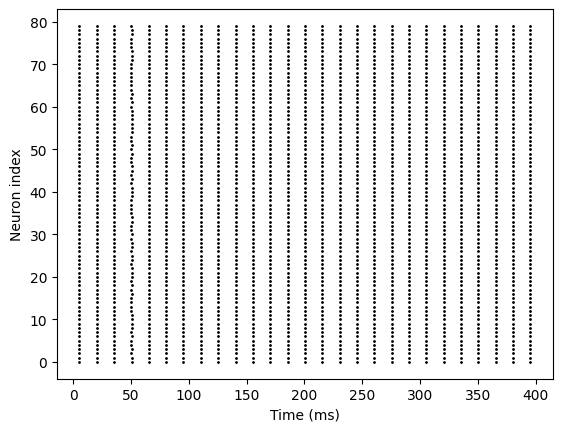

In [164]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)


In [165]:
import numpy as np
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 10.  # Leak Conductance   [nS]
g_Na = 20. * 1000
g_Kd = 6. * 1000  # K Conductance      [nS]
El = -60.  # Resting Potential [mV]
ENa = 50.  # reversal potential (Sodium) [mV]
EK = -90.  # reversal potential (Potassium) [mV]
VT = -63.
V_th = -20.

# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]

# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]

# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]

# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

In [174]:
class ExponCOBA(bp.Projection):
    def __init__(self, num_pre, post, prob, g_max, tau, E):
        super().__init__()
    
        self.proj = bp.dyn.ProjAlignPostMg1(
          comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=num_pre, post=post.num), g_max),
          syn=bp.dyn.Expon.desc(size=post.num, tau=tau),
          out=bp.dyn.COBA.desc(E=E),
          post=post
        )
  
    def update(self, sps):
        return self.proj(sps)
    

In [175]:
class EINet_v3(bp.DynSysGroup):
    def __init__(self, scale=1.):
        super().__init__()

        self.num_exc = int(160 * scale)
        self.num_inh = int(40 * scale)

        self.N = HH2(self.num_exc + self.num_inh)
        self.Esyn = ExponCOBA(self.num_exc, self.N, 0.02, g_max=0.25 / scale, tau=5, E=20.)
        self.Isyn = ExponCOBA(self.num_inh, self.N, 0.02,  g_max=0.25 / scale, tau=10., E=-75)
        print('weights are =' , self.Isyn.proj.comm.weight)
    
    def update(self):
        # update E inputs
        e_sps = self.N.spike[:self.num_exc]
        self.Esyn(e_sps)

        # update I inputs
        i_sps = self.N.spike[self.num_exc:]
        self.Isyn(i_sps)

        # update neurons
        self.N(bm.random.uniform(9,10,200))

        # monitor
        return self.N.spike

weights are = 0.25


  0%|          | 0/4000 [00:00<?, ?it/s]

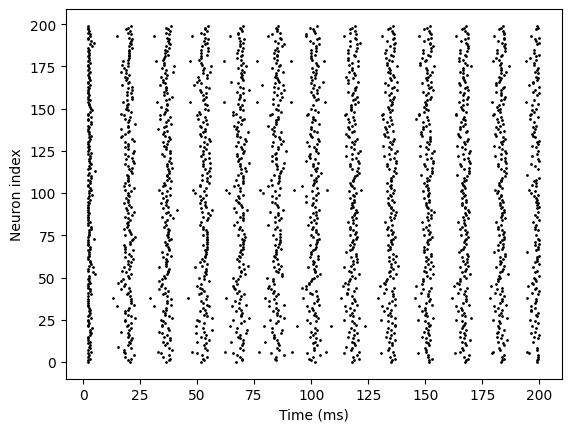

In [176]:
net = EINet_v3(scale=1)
indices = np.arange(4000) # 100 ms
sps = bm.for_loop(net.step_run, indices, progress_bar=True)
bp.visualize.raster_plot(indices * bm.get_dt(), sps, show=True)

In [204]:
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 0.03  # Leak Conductance   [nS]
g_Na = 120. #* 1000
g_Kd = 36. #* 1000  # K Conductance      [nS]
El = -54.4  # Resting Potential [mV]
ENa = 50.  # reversal potential (Sodium) [mV]
EK = -77.  # reversal potential (Potassium) [mV]
# VT = -63.
V_th = -20.

# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]

# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]

# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]

# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

In [205]:
class HH(bp.dyn.NeuDyn):
  def __init__(self, size, method='exp_auto'):
    super(HH, self).__init__(size)

    # variables
    self.V = bm.Variable(El + (bm.random.randn(self.num) * 5 - 5))
    self.m = bm.Variable(bm.zeros(self.num))
    self.n = bm.Variable(bm.zeros(self.num))
    self.h = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.input = bm.Variable(bm.zeros(size))

    def dV(V, t, m, h, n, Isyn):
      gna = g_Na * (m * m * m) * h
      gkd = g_Kd * (n * n * n * n)
      dVdt = (-gl * (V - El) - gna * (V - ENa) - gkd * (V - EK) + Isyn) / Cm
      return dVdt

    def dm(m, t, V, ):
      m_alpha = (0.1*V+4) / (-bm.exp(-4 - 0.1*V)+1) # 0.32 * (13 - V + VT) / (bm.exp((13 - V + VT) / 4) - 1.)
      m_beta = 4.0*bm.exp(-V-65/18.0) #0.28 * (V - VT - 40) / (bm.exp((V - VT - 40) / 5) - 1)
      dmdt = (m_alpha * (1 - m) - m_beta * m)
      return dmdt

    def dh(h, t, V):
      h_alpha =  0.07*bm.exp(-V-65/20.0) #0.128 * bm.exp((17 - V + VT) / 18)
      h_beta =  1/(1+bm.exp(-3.5-0.1*V))  #4. / (1 + bm.exp(-(V - VT - 40) / 5))
      dhdt = (h_alpha * (1 - h) - h_beta * h)
      return dhdt

    def dn(n, t, V):
      
      n_alpha = 0.01*(55.0+V)/ (-bm.exp(-5.5-0.1*V )+1) #0.032 * c / (bm.exp(c / 5) - 1.)
      n_beta =  0.125*bm.exp(-V-65/80.0)  #.5 * bm.exp((10 - V + VT) / 40)
      dndt = (n_alpha * (1 - n) - n_beta * n)
      return dndt

 

    
    # functions
    self.integral = bp.odeint(bp.JointEq([dV, dm, dh, dn]), method=method)

  def update(self):
    tdi = bp.share.get_shargs()
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, tdi.t, Isyn=self.input, dt=tdi.dt)
    self.spike.value = bm.logical_and(self.V < V_th, V >= V_th)
    self.m.value = m
    self.h.value = h
    self.n.value = n
    self.V.value = V
    self.input[:] = 12.

In [206]:
class ExpCOBA(bp.synapses.TwoEndConn):
  def __init__(self, pre, post, conn, g_max=1., delay=0., tau=8.0, E=0.,
               method='exp_auto'):
    super(ExpCOBA, self).__init__(pre=pre, post=post, conn=conn)
    self.check_pre_attrs('spike')
    self.check_post_attrs('input', 'V')

    # parameters
    self.E = E
    self.tau = tau
    self.delay = delay
    self.g_max = g_max
    self.pre2post = self.conn.require('pre2post')

    # variables
    self.g = bm.Variable(bm.zeros(self.post.num))

    # function
    self.integral = bp.odeint(lambda g, t: -g / self.tau, method=method)

  def update(self):
    self.g.value = self.integral(self.g, bp.share['t'], dt=bp.share['dt'])
    post_sps = bm.pre2post_event_sum(self.pre.spike, self.pre2post, self.post.num, self.g_max)
    self.g.value += post_sps
    self.post.input += self.g * (self.E - self.post.V)

In [207]:
class COBAHH(bp.Network):
  def __init__(self, scale=1., method='exp_auto'):
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)
    E = HH(num_exc)
    I = HH(num_inh)
    E2E = ExpCOBA(pre=E, post=E, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ee, g_max=we / scale, tau=taue, method=method)
    E2I = ExpCOBA(pre=E, post=I, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ee, g_max=we / scale, tau=taue, method=method)
    I2E = ExpCOBA(pre=I, post=E, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ei, g_max=wi / scale, tau=taui, method=method)
    I2I = ExpCOBA(pre=I, post=I, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ei, g_max=wi / scale, tau=taui, method=method)

    super(COBAHH, self).__init__(E2E, E2I, I2I, I2E, E=E, I=I)


In [208]:
net = COBAHH()

In [209]:
runner = bp.DSRunner(net, monitors=['E.spike'])
t = runner.run(4000.)

  0%|          | 0/80000 [00:00<?, ?it/s]

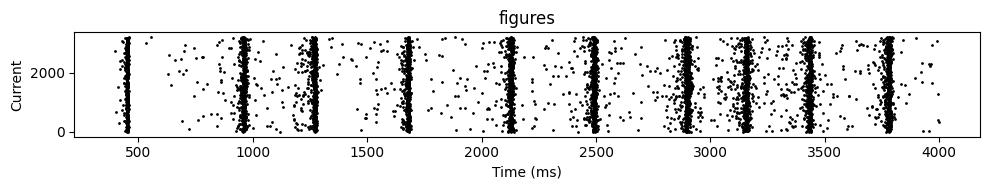

In [210]:
fig, gs = bp.visualize.get_figure(1, 1, 2, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'])
plt.title('figures') #f'gc={gc}, gEE={gEE}, gEI={gEI}, gIE={gIE}, gII={gII}, seed={seed}')
plt.ylabel('Current')
plt.tight_layout()
# if save_fig:
# plt.savefig('batista_figs/hist.png')
# else:
# plt.show()
# plt.close(fig)

